In [ ]:
#| hide

# This cell will not be rendered but is to hide warnings and limit the rows shown

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('statsforecast').setLevel(logging.ERROR)

import pandas as pd
pd.set_option('display.max_rows', 6)

# Seasonal Exponential Smoothing Optimized Model

> Step-by-step guide on using the `SeasonalExponentialSmoothingOptimized Model` with `Statsforecast`.

During this walkthrough, we will become familiar with the main `StatsForecast` class and some relevant methods such as `StatsForecast.plot`, `StatsForecast.forecast` and `StatsForecast.cross_validation` in other.

## Table of Contents

* [Introduction](#introduction)
* [Seasonal Exponential Smoothing Optimized Model](#model)
* [Loading libraries and data](#loading)
* [Explore data with the plot method](#plotting)
* [Split the data into training and testing](#splitting)
* [Implementation of SeasonalExponentialSmoothingOptimized with StatsForecast](#implementation)
* [Cross-validation](#cross_validate)
* [Model evaluation](#evaluate)
* [References](#references)

## Introduction <a class="anchor" id="introduction"></a>

The Seasonal Exponential Smoothing Optimized (SESO) model is a forecasting technique used to predict future values of a time series that exhibits seasonal patterns. It is a variant of the exponential smoothing method, which uses a combination of past and predicted values to generate a prediction.

The SESO algorithm uses an optimization approach to find the optimal values of the seasonal exponential smoothing parameters. These parameters include the smoothing coefficients for the levels, trends, and seasonal components of the time series.

The SESO model is particularly useful for forecasting time series with pronounced seasonal patterns, such as seasonal product sales or seasonal temperatures, and many other areas. By using SESO, accurate and useful forecasts can be generated for business planning and decision making.

## Seasonal Exponential Smoothing Model <a class="anchor" id="model"></a>

The SESO model is based on the exponential smoothing method, which uses a combination of past and predicted values to generate a prediction. The mathematical formula for the SESO model is as follows:

$$\hat{y}{t+1,s} = \alpha y_t + (1-\alpha) \hat{y}{t-1,s}$$

Where:
- $\hat{y}{t+1,s}$ is the forecast for the next period of the season $s$.
- $\alpha$ is the smoothing parameter that is optimized by minimizing the squared error.
- $y_t$ is the current observation of station $s$ in period $t$.
- $\hat{y}{t-1,s}$ is the forecast for the previous period of the season $s$.

The equation indicates that the forecast value for the next season period $s$ is calculated as a weighted combination of the current observation and the previous forecast for the same station. The smoothing parameter $\alpha$ controls the relative influence of these two terms on the final prediction. A high value of α gives more weight to the current observation and less weight to the previous forecast, making the model more sensitive to recent changes in the time series. A low value of $\alpha$, on the other hand, gives more weight to the previous forecast and less weight to the current observation, making the model more stable and smooth.

The optimal value of the smoothing parameter $\alpha$ is determined by minimizing the squared error between the forecasts generated by the model and the actual values of the time series.

### Model selection

Model selection in the context of the SESO model refers to the process of choosing the optimal values of the smoothing parameters and the seasonal component for the model. The optimal values of these parameters are the ones that result in the best forecast performance for the given data set.

A great advantage of the ETS statistical framework is that information criteria can be used for model selection. The $AIC, AIC_c$ and $BIC$, that also can be used here to determine which of the ETS models is most appropriate for a given time series.

For ETS models, Akaike’s Information Criterion (AIC) is defined as
$$\text{AIC} = -2\log(L) + 2k,$$

where $L$ is the likelihood of the model and $k$ is the total number of parameters and initial states that have been estimated (including the residual variance).

The AIC corrected for small sample bias ($AIC_c$) is defined as
$$\text{AIC}_{\text{c}} = \text{AIC} + \frac{2k(k+1)}{T-k-1},$$

and the Bayesian Information Criterion (BIC) is
$$\text{BIC} = \text{AIC} + k[\log(T)-2].$$

These criteria balance the goodness of fit with the complexity of the model and provide a way to choose the model that maximizes the likelihood of the data while minimizing the number of parameters.

In addition to these techniques, expert judgment and domain knowledge can also be used to select the optimal SESO model. This involves considering the underlying dynamics of the time series, the patterns of seasonality, and any other relevant factors that may influence the choice of the model.

Overall, the process of model selection for the SESO model involves a combination of statistical techniques, information criteria, and expert judgment to identify the optimal values of the smoothing parameters and the seasonal component that result in the best forecast performance for the given data set.

## Loading libraries and data <a class="anchor" id="loading"></a>

:::{.callout-tip} Statsforecast will be needed. To install, see [instructions](../getting-started/Installation.ipynb). :::

Next, we import plotting libraries and configure the plotting style.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.style.use('grayscale') # fivethirtyeight  grayscale  classic
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#008080',  # #212946
    'axes.facecolor': '#008080',
    'savefig.facecolor': '#008080',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#000000',  #2A3459
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)


from pylab import rcParams
rcParams['figure.figsize'] = (18,7)

### Read Data

In [ ]:
import pandas as pd

df=pd.read_csv("https://raw.githubusercontent.com/Naren8520/Serie-de-tiempo-con-Machine-Learning/main/Data/ads.csv")
df.head()

,Time,Ads
0,2017-09-13T00:00:00,80115
1,2017-09-13T01:00:00,79885
2,2017-09-13T02:00:00,89325
3,2017-09-13T03:00:00,101930
4,2017-09-13T04:00:00,121630


The input to StatsForecast is always a data frame in long format with three columns: unique_id, ds and y:

* The `unique_id` (string, int or category) represents an identifier for the series.

* The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast.

In [ ]:
df["unique_id"]="1"
df.columns=["ds", "y", "unique_id"]
df.head()

,ds,y,unique_id
0,2017-09-13T00:00:00,80115,1
1,2017-09-13T01:00:00,79885,1
2,2017-09-13T02:00:00,89325,1
3,2017-09-13T03:00:00,101930,1
4,2017-09-13T04:00:00,121630,1


In [ ]:
print(df.dtypes)

ds           object
y             int64
unique_id    object
dtype: object


We can see that our time variable `(ds)` is in an object format, we need to convert to a date format

In [ ]:
df["ds"] = pd.to_datetime(df["ds"])

## Explore Data with the plot method <a class="anchor" id="plotting"></a>

Plot some series using the plot method from the StatsForecast class. This method prints a random series from the dataset and is useful for basic EDA.

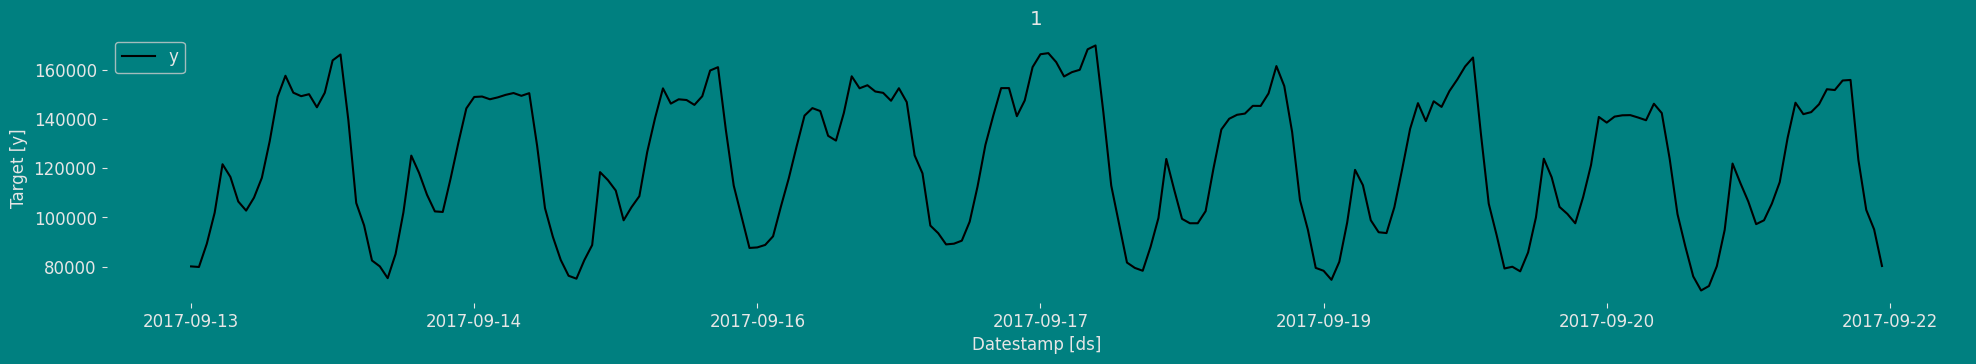

In [ ]:
from statsforecast import StatsForecast

StatsForecast.plot(df)

### The Augmented Dickey-Fuller Test

An Augmented Dickey-Fuller (ADF) test is a type of statistical test that determines whether a unit root is present in time series data. Unit roots can cause unpredictable results in time series analysis. A null hypothesis is formed in the unit root test to determine how strongly time series data is affected by a trend. By accepting the null hypothesis, we accept the evidence that the time series data is not stationary. By rejecting the null hypothesis or accepting the alternative hypothesis, we accept the evidence that the time series data is generated by a stationary process. This process is also known as stationary trend. The values of the ADF test statistic are negative. Lower ADF values indicate a stronger rejection of the null hypothesis.

Augmented Dickey-Fuller Test is a common statistical test used to test whether a given time series is stationary or not. We can achieve this by defining the null and alternate hypothesis.

Null Hypothesis: Time Series is non-stationary. It gives a time-dependent trend.
Alternate Hypothesis: Time Series is stationary. In another term, the series doesn’t depend on time.

ADF or t Statistic < critical values: Reject the null hypothesis, time series is stationary.
ADF or t Statistic > critical values: Failed to reject the null hypothesis, time series is non-stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller

def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Dickey-Fuller test results for columns: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of observations used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("The data is stationary")
    else:
        print("Conclusion:====>")
        print("The null hypothesis cannot be rejected")
        print("The data is not stationary")

In [ ]:
Augmented_Dickey_Fuller_Test_func(df["y"],'Ads')

Dickey-Fuller test results for columns: Ads
Test Statistic         -7.089634e+00
p-value                 4.444804e-10
No Lags Used            9.000000e+00
                            ...     
Critical Value (1%)    -3.462499e+00
Critical Value (5%)    -2.875675e+00
Critical Value (10%)   -2.574304e+00
Length: 7, dtype: float64
Conclusion:====>
Reject the null hypothesis
The data is stationary


### Autocorrelation plots

The important characteristics of Autocorrelation (ACF) and Partial Autocorrelation (PACF) are as follows:

Autocorrelation (ACF):
1. Identify patterns of temporal dependence: The ACF shows the correlation between an observation and its lagged values at different time intervals. Helps identify patterns of temporal dependency in a time series, such as the presence of trends or seasonality.

2. Indicates the "memory" of the series: The ACF allows us to determine how much past observations influence future ones. If the ACF shows significant autocorrelations in several lags, it indicates that the series has a long-term memory and that past observations are relevant to predict future ones.

3. Helps identify MA (moving average) models: The shape of the ACF can reveal the presence of moving average components in the time series. Lags where the ACF shows a significant correlation may indicate the order of an MA model.

Partial Autocorrelation (PACF):
1. Identify direct dependence: Unlike the ACF, the PACF eliminates the indirect effects of intermediate lags and measures the direct correlation between an observation and its lagged values. It helps to identify the direct dependence between an observation and its lag values, without the influence of intermediate lags.

2. Helps to identify AR (autoregressive) models: The shape of the PACF can reveal the presence of autoregressive components in the time series. Lags in which the PACF shows a significant correlation may indicate the order of an AR model.

3. Used in conjunction with the ACF: The PACF is used in conjunction with the ACF to determine the order of an AR or MA model. By analyzing both the ACF and the PACF, significant lags can be identified and a model suitable for time series analysis and forecasting can be built.

In summary, the ACF and the PACF are complementary tools in time series analysis that provide information on time dependence and help identify the appropriate components to build forecast models.

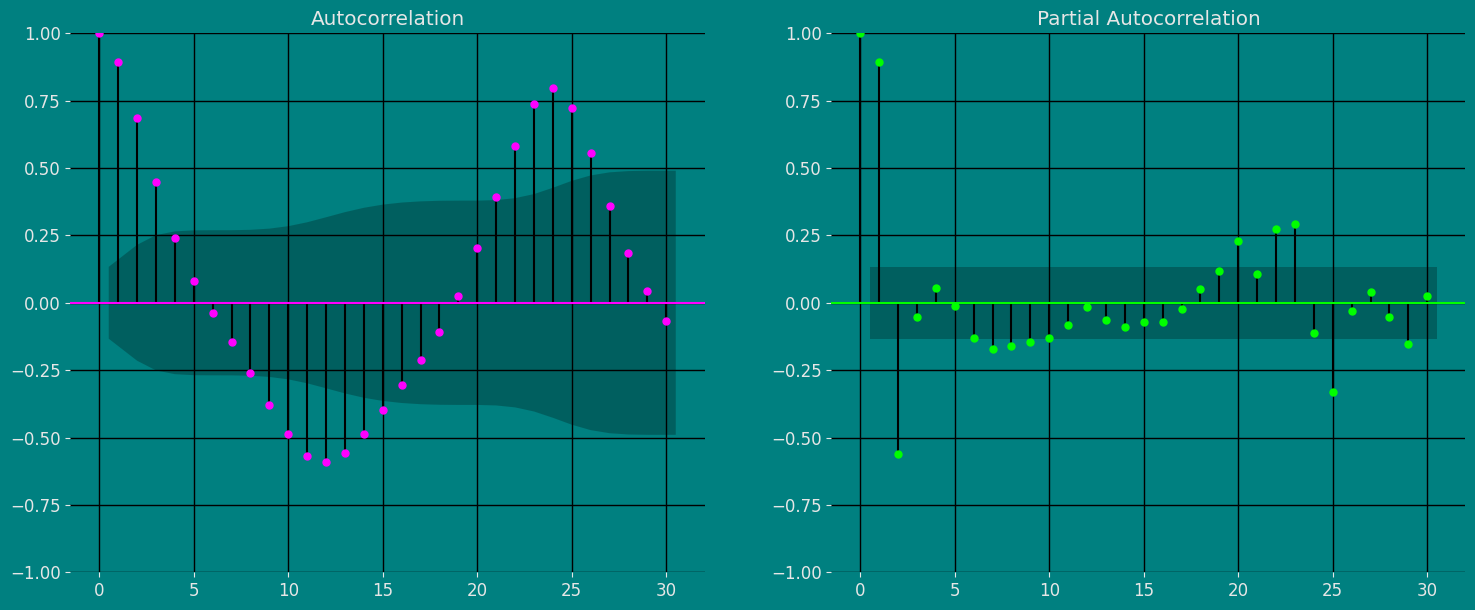

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(df["y"],  lags=30, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

# Grafico
plot_pacf(df["y"],  lags=30, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

#plt.savefig("Gráfico de Densidad y qq")
plt.show();

### Decomposition of the time series

How to decompose a time series and why?

In time series analysis to forecast new values, it is very important to know past data. More formally, we can say that it is very important to know the patterns that values follow over time. There can be many reasons that cause our forecast values to fall in the wrong direction. Basically, a time series consists of four components. The variation of those components causes the change in the pattern of the time series. These components are:

* **Level:** This is the primary value that averages over time.
* **Trend:** The trend is the value that causes increasing or decreasing patterns in a time series.
* **Seasonality:** This is a cyclical event that occurs in a time series for a short time and causes short-term increasing or decreasing patterns in a time series.
* **Residual/Noise:** These are the random variations in the time series.

Combining these components over time leads to the formation of a time series. Most time series consist of level and noise/residual and trend or seasonality are optional values.

If seasonality and trend are part of the time series, then there will be effects on the forecast value. As the pattern of the forecasted time series may be different from the previous time series.

The combination of the components in time series can be of two types:
* Additive
* Multiplicative

### Additive time series

If the components of the time series are added to make the time series. Then the time series is called the additive time series. By visualization, we can say that the time series is additive if the increasing or decreasing pattern of the time series is similar throughout the series. The mathematical function of any additive time series can be represented by:
$$y(t) = level + Trend + seasonality + noise$$

### Multiplicative time series

If the components of the time series are multiplicative together, then the time series is called a multiplicative time series. For visualization, if the time series is having exponential growth or decline with time, then the time series can be considered as the multiplicative time series. The mathematical function of the multiplicative time series can be represented as.

$$y(t) = Level * Trend * seasonality * Noise$$

### Additive

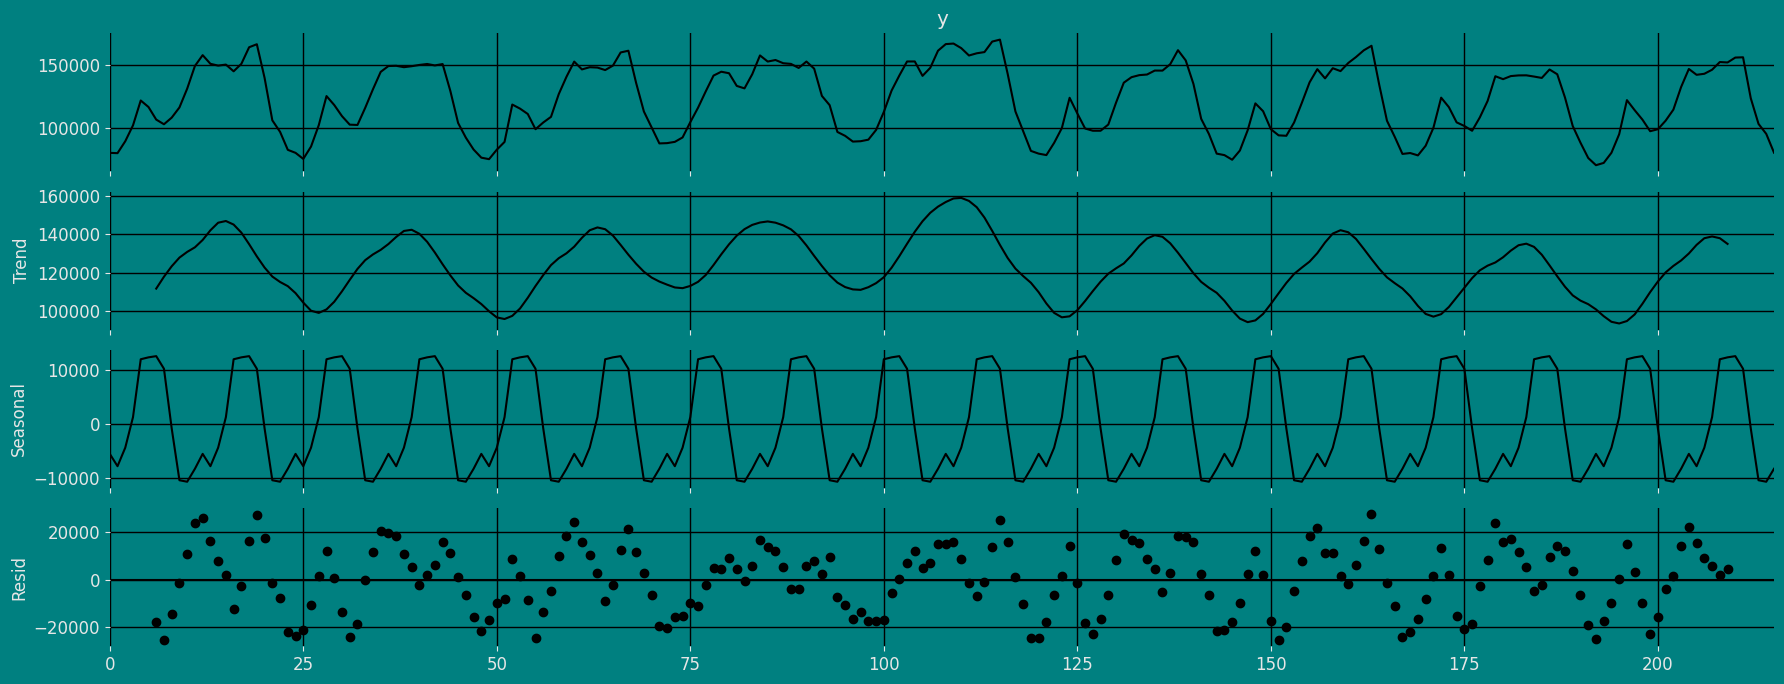

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose 
a = seasonal_decompose(df["y"], model = "additive", period=12)
a.plot();

### Multiplicative

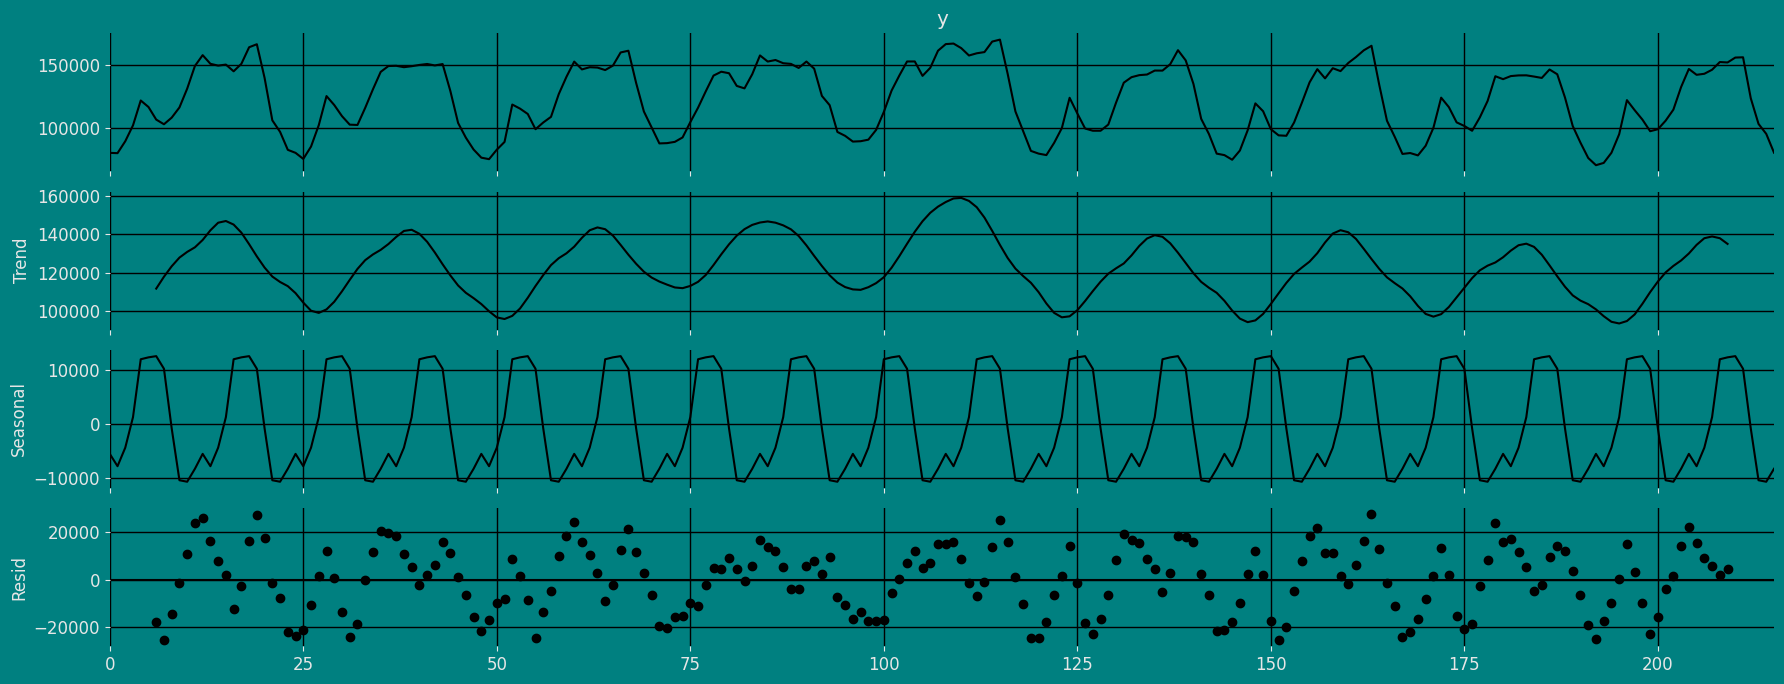

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose 
a = seasonal_decompose(df["y"], model = "Multiplicative", period=12)
a.plot();

## Split the data into training and testing<a class="anchor" id="splitting"></a>

Let's divide our data into sets

1. Data to train our `Seasonal Exponential Smoothing Optimized Model`.
2. Data to test our model

For the test data we will use the last 30 hours to test and evaluate the performance of our model.

In [ ]:
train = df[df.ds<='2017-09-20 17:00:00'] 
test = df[df.ds>'2017-09-20 17:00:00'] 

In [ ]:
train.shape, test.shape

((186, 3), (30, 3))

Now let's plot the training data and the test data.

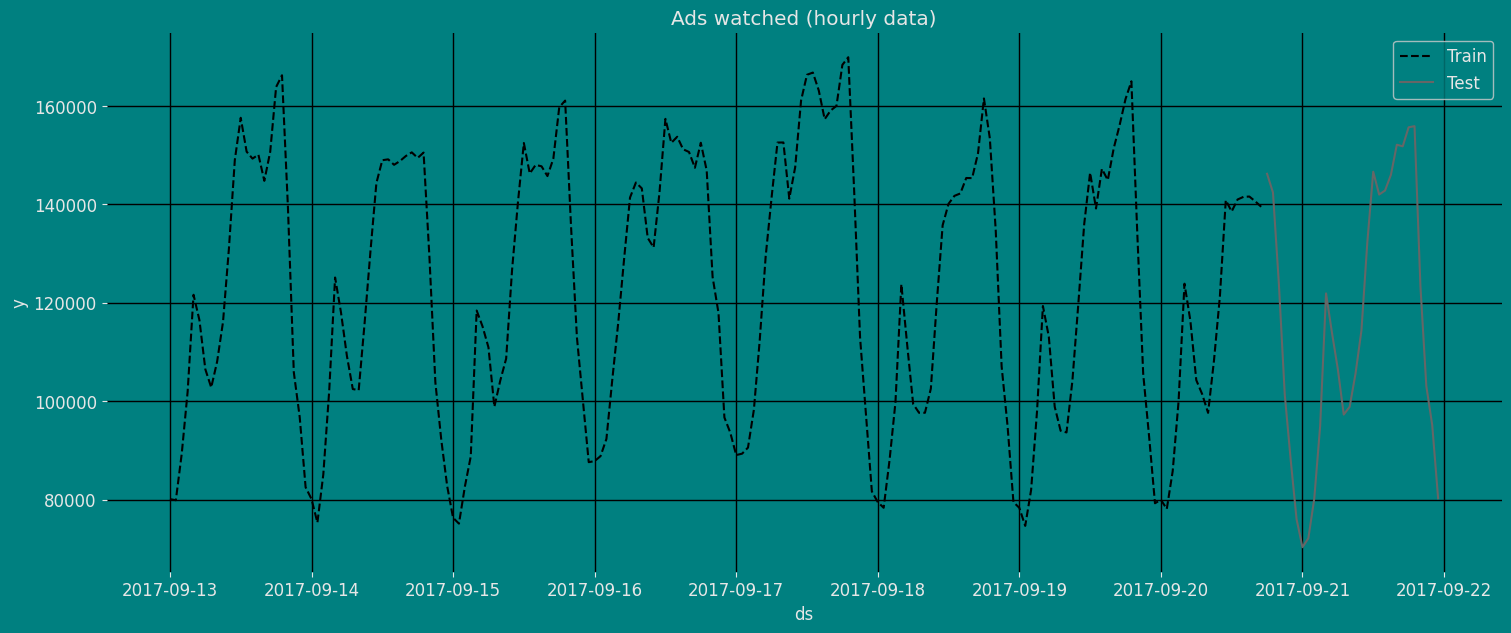

In [ ]:
sns.lineplot(train,x="ds", y="y", label="Train", linestyle="--")
sns.lineplot(test, x="ds", y="y", label="Test")
plt.title("Ads watched (hourly data)");
plt.show()

## Implementation of SeasonalExponentialSmoothingOptimized with StatsForecast <a class="anchor" id="implementation"></a>

To also know more about the parameters of the functions of the `SeasonalExponentialSmoothingOptimized Model`, they are listed below. For more information, visit the [documentation](https://nixtla.github.io/statsforecast/src/core/models.html#seasonalsmooth).

```
alpha : float
    Smoothing parameter.
season_length : int
    Number of observations per unit of time. Ex: 24 Hourly data.
alias : str
    Custom name of the model.
prediction_intervals : Optional[ConformalIntervals]
    Information to compute conformal prediction intervals.
    By default, the model will compute the native prediction
    intervals.
```

### Load libraries

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import SeasonalExponentialSmoothingOptimized

### Building Model
Import and instantiate the models. Setting the argument is sometimes tricky. This article on [Seasonal periods](https://robjhyndman.com/hyndsight/seasonal-periods/) by the master, Rob Hyndmann, can be useful for `season_length`.


In [ ]:
season_length = 24 # Hourly data 
horizon = len(test) # number of predictions

models = [SeasonalExponentialSmoothingOptimized(season_length=season_length)]

We fit the models by instantiating a new StatsForecast object with the following parameters:

models: a list of models. Select the models you want from models and import them.

* `freq:` a string indicating the frequency of the data. (See [panda’s available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).)

* `n_jobs:` n_jobs: int, number of jobs used in the parallel processing, use -1 for all cores.

* `fallback_model:` a model to be used if a model fails.

Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame.

In [ ]:
sf = StatsForecast(df=df,
                   models=models,
                   freq='H', 
                   n_jobs=-1)

### Fit the Model

In [ ]:
sf.fit()

StatsForecast(models=[SeasESOpt])

Let's see the results of our `Seasonal Exponential Smoothing Optimized Model`. We can observe it with the following instruction:

In [ ]:
result=sf.fitted_[0,0].model_
result

{'mean': array([ 80116.2  ,  79812.98 ,  84372.74 ,  99043.75 , 121514.94 ,
        116611.32 , 108388.39 , 103424.516, 108289.664, 116023.664,
        121505.336, 139466.77 , 146281.33 , 149037.22 , 149215.86 ,
        146367.08 , 148183.7  , 150684.8  , 157380.17 , 156142.53 ,
        127853.48 , 103063.23 ,  94190.15 ,  82520.19 ], dtype=float32),
 'fitted': array([       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,  80115.   ,
         79885.   ,  89325.   , 101930.   , 121630.   , 116475.   ,
        106495.   , 102795.   , 108055.   , 116125.   , 131030.   ,
        149020.   , 157590.   , 150715.   , 149295.   , 150100.   ,
        144780.   , 150690.   , 163840.   , 166235.   , 139520.   ,
        105895.   ,  9678

Let us now visualize the fitted values of our models.

As we can see, the result obtained above has an output in a dictionary, to extract each element from the dictionary we are going to use the `.get()` function to extract the element and then we are going to save it in a `pd.DataFrame()`.

In [ ]:
fitted=pd.DataFrame(result.get("fitted"), columns=["fitted"])
fitted["ds"]=df["ds"]
fitted

,fitted,ds
0,NaN,2017-09-13 00:00:00
1,NaN,2017-09-13 01:00:00
2,NaN,2017-09-13 02:00:00
...,...,...
213,101402.406250,2017-09-21 21:00:00
214,93899.984375,2017-09-21 22:00:00
215,82542.765625,2017-09-21 23:00:00


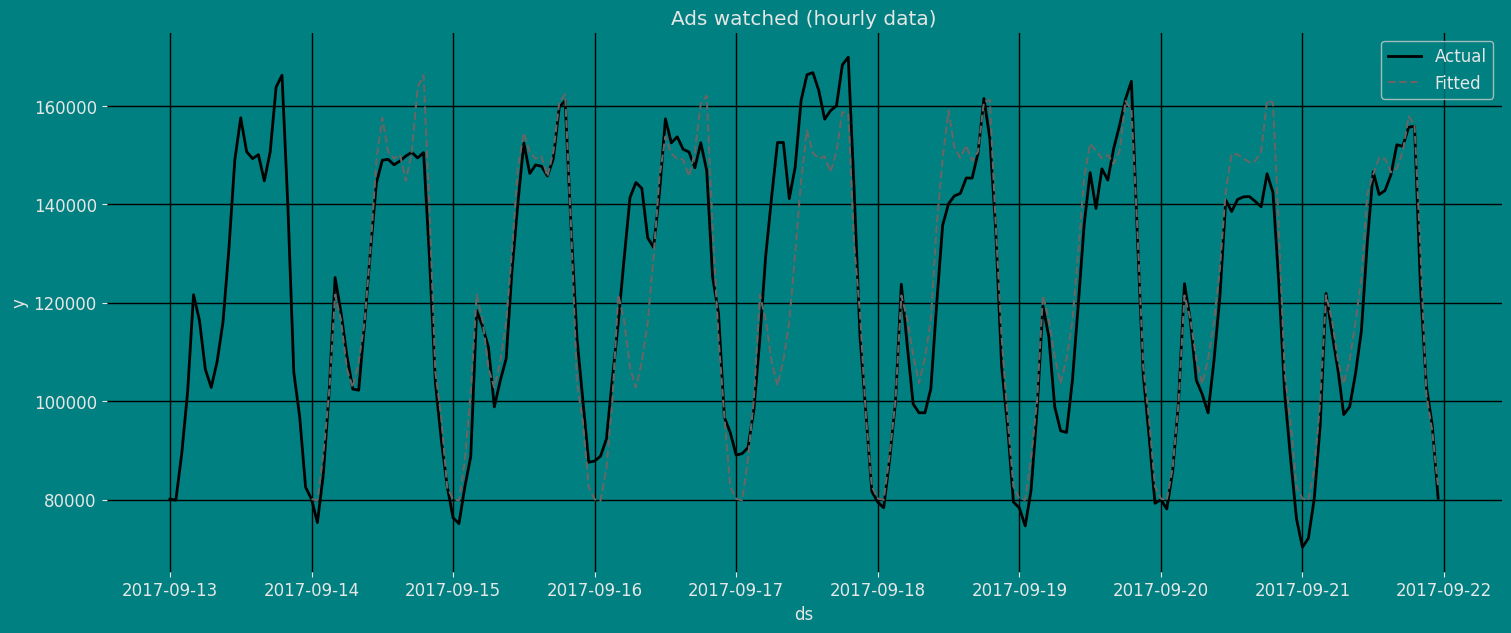

In [ ]:
sns.lineplot(df, x="ds", y="y", label="Actual", linewidth=2)
sns.lineplot(fitted,x="ds", y="fitted", label="Fitted", linestyle="--" )

plt.title("Ads watched (hourly data)");
plt.show()

### Forecast Method

If you want to gain speed in productive settings where you have multiple series or models we recommend using the `StatsForecast.forecast` method instead of `.fit` and `.predict`.

The main difference is that the `.forecast` doest not store the fitted values and is highly scalable in distributed environments.

The forecast method takes two arguments: forecasts next `h` (horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 12 months ahead.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals. Depending on your computer, this step should take around 1min.

In [ ]:
# Prediction
Y_hat = sf.forecast(horizon, fitted=True)
Y_hat

,ds,SeasESOpt
unique_id,,
1,2017-09-22 00:00:00,80116.203125
1,2017-09-22 01:00:00,79812.976562
1,2017-09-22 02:00:00,84372.742188
...,...,...
1,2017-09-23 03:00:00,99043.750000
1,2017-09-23 04:00:00,121514.937500
1,2017-09-23 05:00:00,116611.320312


In [ ]:
values=sf.forecast_fitted_values()
values.head()

,ds,y,SeasESOpt
unique_id,,,
1,2017-09-13 00:00:00,80115.0,NaN
1,2017-09-13 01:00:00,79885.0,NaN
1,2017-09-13 02:00:00,89325.0,NaN
1,2017-09-13 03:00:00,101930.0,NaN
1,2017-09-13 04:00:00,121630.0,NaN


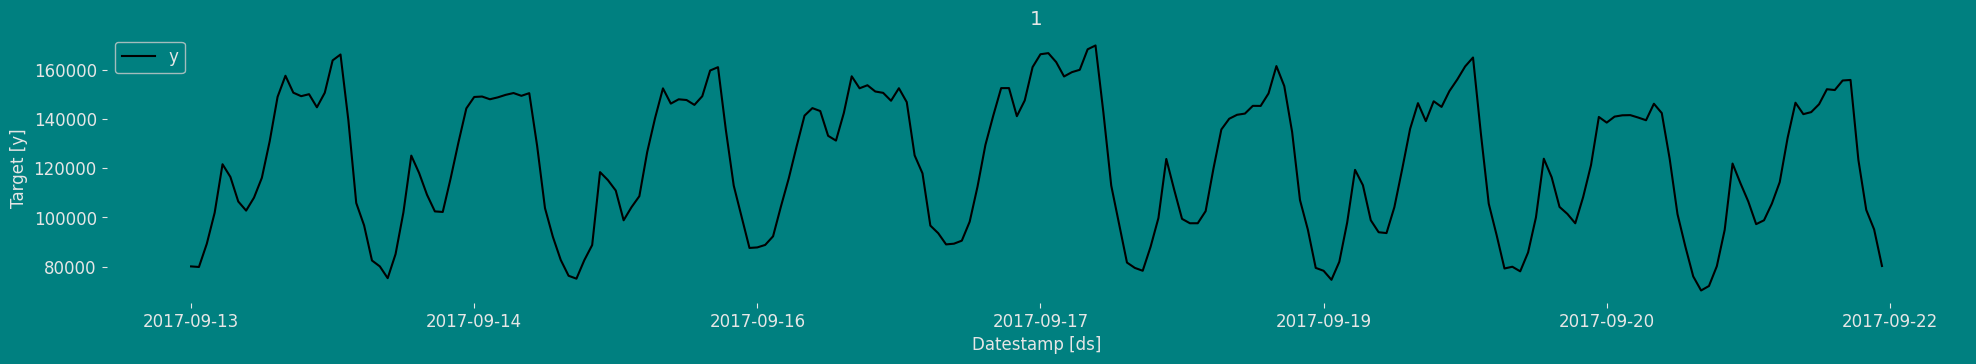

In [ ]:
StatsForecast.plot(values)

In [ ]:
Y_hat=Y_hat.reset_index()
Y_hat

,unique_id,ds,SeasESOpt
0,1,2017-09-22 00:00:00,80116.203125
1,1,2017-09-22 01:00:00,79812.976562
2,1,2017-09-22 02:00:00,84372.742188
...,...,...,...
27,1,2017-09-23 03:00:00,99043.750000
28,1,2017-09-23 04:00:00,121514.937500
29,1,2017-09-23 05:00:00,116611.320312


In [ ]:
Y_hat1= pd.concat([df,Y_hat])
Y_hat1

,ds,y,unique_id,SeasESOpt
0,2017-09-13 00:00:00,80115.0,1,NaN
1,2017-09-13 01:00:00,79885.0,1,NaN
2,2017-09-13 02:00:00,89325.0,1,NaN
...,...,...,...,...
27,2017-09-23 03:00:00,NaN,1,99043.750000
28,2017-09-23 04:00:00,NaN,1,121514.937500
29,2017-09-23 05:00:00,NaN,1,116611.320312


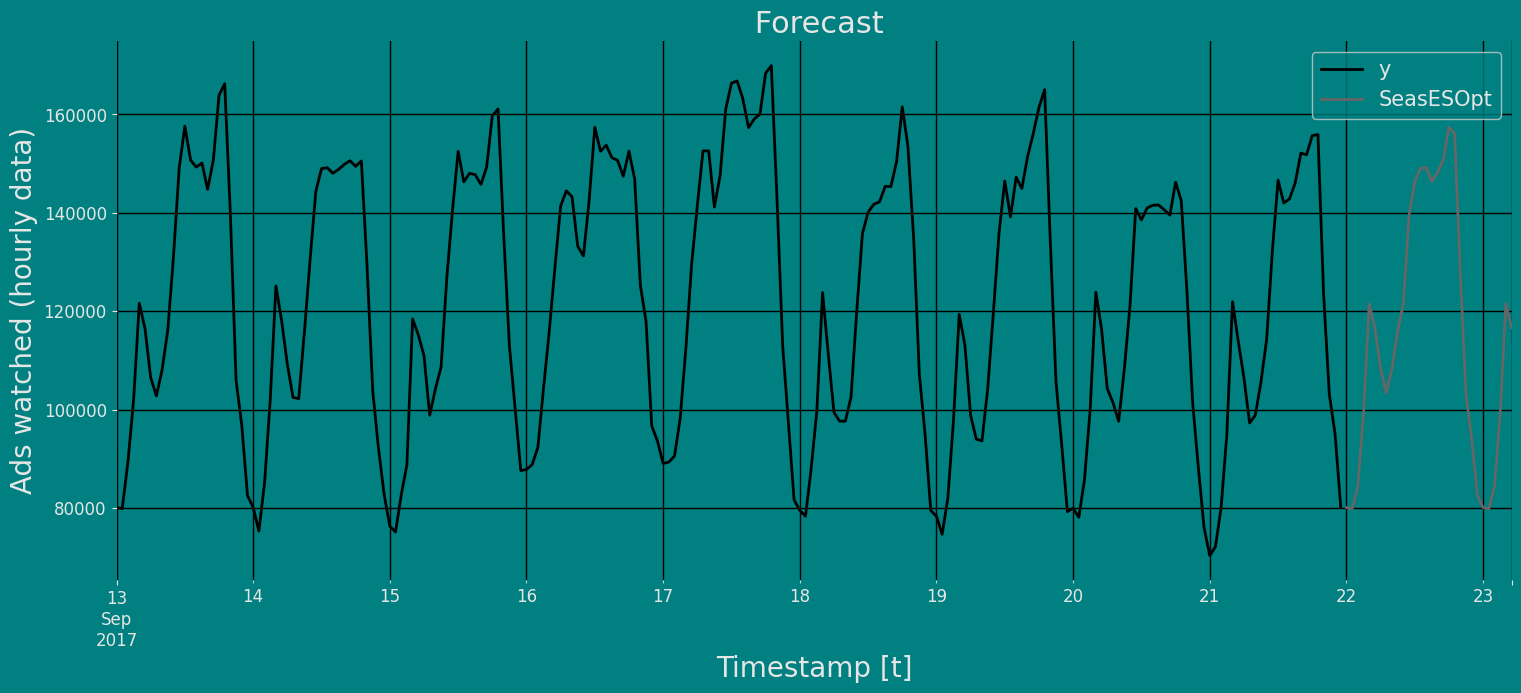

In [ ]:
fig, ax = plt.subplots(1, 1)
plot_df = pd.concat([df,Y_hat]).set_index('ds')
plot_df[['y', "SeasESOpt"]].plot(ax=ax, linewidth=2)
ax.set_title(' Forecast', fontsize=22)
ax.set_ylabel('Ads watched (hourly data)', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid(True)

### Predict method with confidence interval

To generate forecasts use the predict method.

The predict method takes two arguments: forecasts the next `h` (for horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 30 hours ahead.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals.

This step should take less than 1 second.

In [ ]:
forecast_df = sf.predict(h=horizon) 
forecast_df

,ds,SeasESOpt
unique_id,,
1,2017-09-22 00:00:00,80116.203125
1,2017-09-22 01:00:00,79812.976562
1,2017-09-22 02:00:00,84372.742188
...,...,...
1,2017-09-23 03:00:00,99043.750000
1,2017-09-23 04:00:00,121514.937500
1,2017-09-23 05:00:00,116611.320312


We can join the forecast result with the historical data using the pandas function `pd.concat()`, and then be able to use this result for graphing.

In [ ]:
df_plot= pd.concat([df, forecast_df]).set_index('ds')
df_plot

,y,unique_id,SeasESOpt
ds,,,
2017-09-13 00:00:00,80115.0,1.0,NaN
2017-09-13 01:00:00,79885.0,1.0,NaN
2017-09-13 02:00:00,89325.0,1.0,NaN
...,...,...,...
2017-09-23 03:00:00,NaN,NaN,99043.750000
2017-09-23 04:00:00,NaN,NaN,121514.937500
2017-09-23 05:00:00,NaN,NaN,116611.320312


Now let's visualize the result of our forecast and the historical data of our time series.

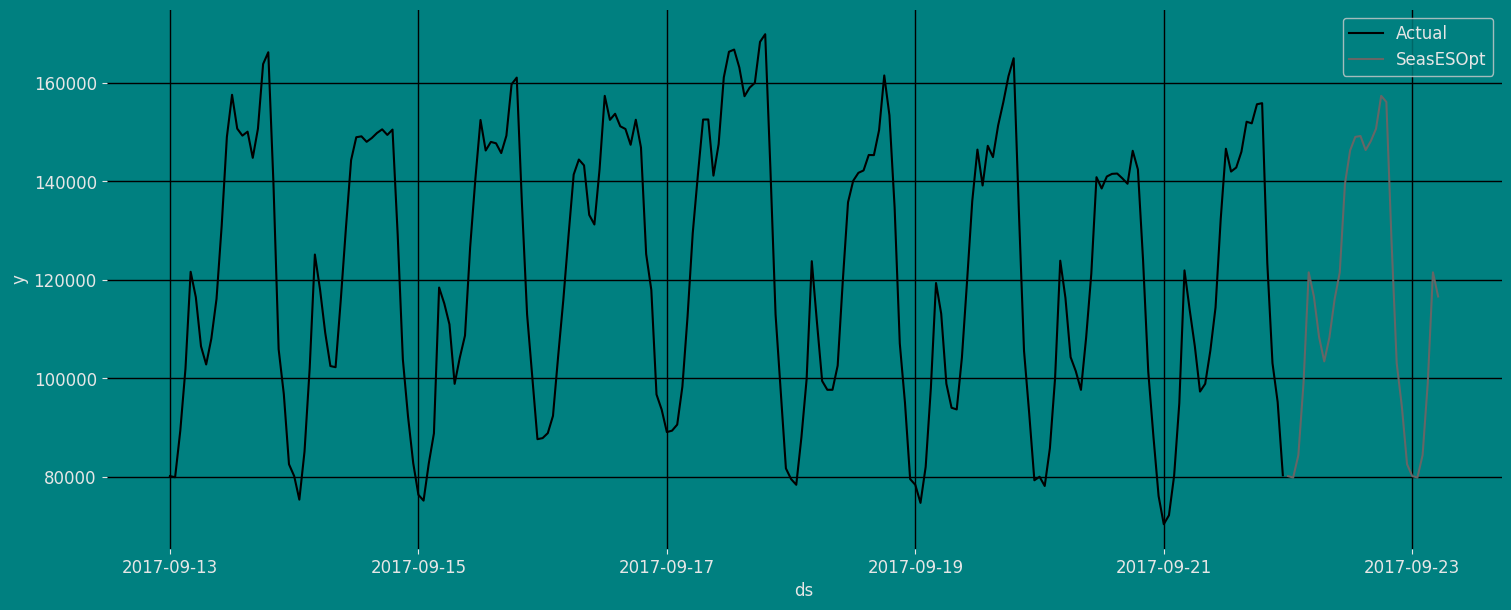

In [ ]:
sns.lineplot(df_plot,x="ds", y="y", label="Actual")
sns.lineplot(df_plot, x="ds", y="SeasESOpt", label="SeasESOpt")
plt.show()

Let's plot the same graph using the plot function that comes in `Statsforecast`, as shown below.

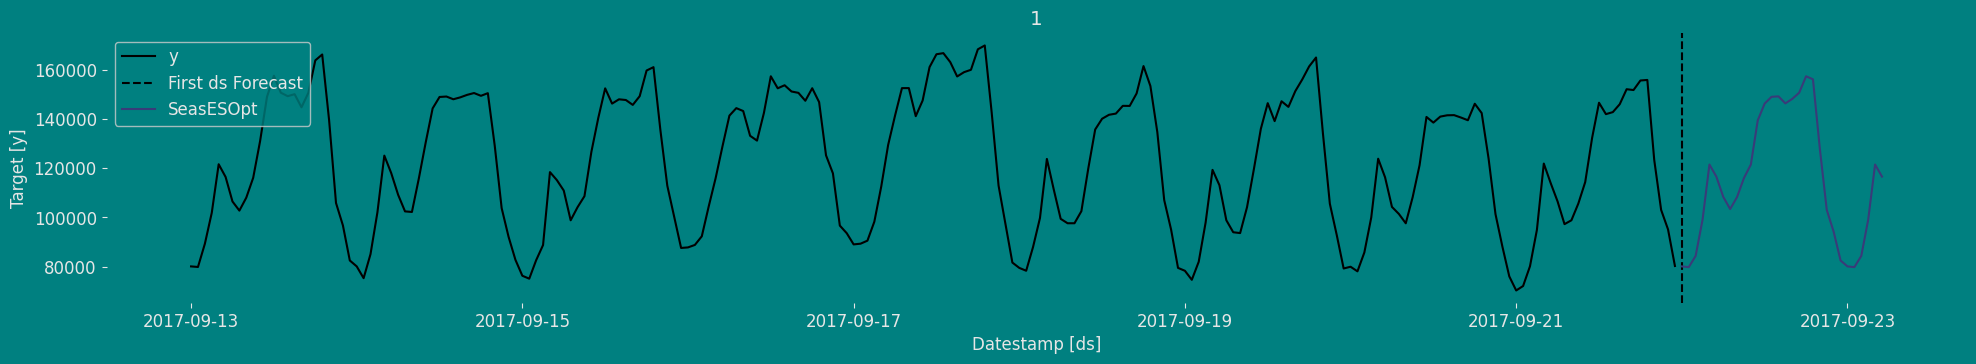

In [ ]:
sf.plot(df, forecast_df)

## Cross-validation <a class="anchor" id="cross_validate"></a>

In previous steps, we’ve taken our historical data to predict the future. However, to asses its accuracy we would also like to know how the model would have performed in the past. To assess the accuracy and robustness of your models on your data perform Cross-Validation.

With time series data, Cross Validation is done by defining a sliding window across the historical data and predicting the period following it. This form of cross-validation allows us to arrive at a better estimation of our model’s predictive abilities across a wider range of temporal instances while also keeping the data in the training set contiguous as is required by our models.

The following graph depicts such a Cross Validation Strategy:

![](https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif)

### Perform time series cross-validation

Cross-validation of time series models is considered a best practice but most implementations are very slow. The statsforecast library implements cross-validation as a distributed operation, making the process less time-consuming to perform. If you have big datasets you can also perform Cross Validation in a distributed cluster using Ray, Dask or Spark.

In this case, we want to evaluate the performance of each model for the last 5 months `(n_windows=)`, forecasting every second months `(step_size=12)`. Depending on your computer, this step should take around 1 min.

The cross_validation method from the StatsForecast class takes the following arguments.

* `df:` training data frame

* `h (int):` represents h steps into the future that are being forecasted. In this case, 12 months ahead.

* `step_size (int):` step size between each window. In other words: how often do you want to run the forecasting processes.

* `n_windows(int):` number of windows used for cross validation. In other words: what number of forecasting processes in the past do you want to evaluate.

In [ ]:
crossvalidation_df = sf.cross_validation(df=df,
                                         h=horizon,
                                         step_size=30,
                                         n_windows=3)

The crossvaldation_df object is a new data frame that includes the following columns:

* `unique_id:` index. If you dont like working with index just run `crossvalidation_df.resetindex()`.
* `ds:` datestamp or temporal index
* `cutoff:` the last datestamp or temporal index for the `n_windows`.
* `y:` true value
* `model:` columns with the model’s name and fitted value.

In [ ]:
crossvalidation_df

,ds,cutoff,y,SeasESOpt
unique_id,,,,
1,2017-09-18 06:00:00,2017-09-18 05:00:00,99440.0,141401.750000
1,2017-09-18 07:00:00,2017-09-18 05:00:00,97655.0,152474.250000
1,2017-09-18 08:00:00,2017-09-18 05:00:00,97655.0,152482.796875
...,...,...,...,...
1,2017-09-21 21:00:00,2017-09-20 17:00:00,103080.0,105600.390625
1,2017-09-21 22:00:00,2017-09-20 17:00:00,95155.0,96717.390625
1,2017-09-21 23:00:00,2017-09-20 17:00:00,80285.0,82608.343750


## Evaluate Model <a class="anchor" id="evaluate"></a>

We can now compute the accuracy of the forecast using an appropiate accuracy metric. Here we’ll use the Root Mean Squared Error (RMSE). To do this, we first need to `install datasetsforecast`, a Python library developed **by Nixtla** that includes a function to compute the RMSE.

In [ ]:
%%capture
!pip install datasetsforecast

In [ ]:
from datasetsforecast.losses import rmse

The function to compute the RMSE takes two arguments:

1. The actual values.
2. The forecasts, in this case, `Seasonal Exponential Smoothing Optimized Model`.

In [ ]:
rmse = rmse(crossvalidation_df['y'], crossvalidation_df["SeasESOpt"])
print("RMSE using cross-validation: ", rmse)

RMSE using cross-validation:  16560.705


## References <a class="anchor" id="references"></a>


1. Changquan Huang • Alla Petukhina. Springer series (2022). Applied Time Series Analysis and Forecasting with Python. 
2. Ivan Svetunkov. [Forecasting and Analytics with the Augmented Dynamic Adaptive Model (ADAM)](https://openforecast.org/adam/)
3. [James D. Hamilton. Time Series Analysis Princeton University Press, Princeton, New Jersey, 1st Edition, 1994.](https://press.princeton.edu/books/hardcover/9780691042893/time-series-analysis)
4. [Nixtla Parameters](https://nixtla.github.io/statsforecast/src/core/models.html#arch-model).
5. [Pandas available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).
6. [Rob J. Hyndman and George Athanasopoulos (2018). “Forecasting principles and practice, Time series cross-validation”.](https://otexts.com/fpp3/tscv.html).
7. [Seasonal periods- Rob J Hyndman](https://robjhyndman.com/hyndsight/seasonal-periods/).